### BMI 500 - Homework 7

The resources that were consulted in this analysis are located in the References section of the report for this homework.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime

Read in clinical information csv files as pandas dataframes

In [2]:
labitems = pd.read_csv("clinical/D_LABITEMS.csv") # Lab Items csv
labevents = pd.read_csv("clinical/LABEVENTS.csv") # Lab Events csv

Connect and store in SQL databse using sqlite. Set up cursor. 

In [3]:
c = sqlite3.connect("clinicalDB.db") # open connection to new SQL databse
labitems.to_sql('LABITEMS', c) # add lab items csv to clinical 
labevents.to_sql('LABEVENTS', c) # add lab items csv to clinical 
cur = c.cursor

View data in LABITEMS using sqlite and pandas

In [4]:
q = pd.read_sql_query("SELECT * FROM LABITEMS", c)
q

,index,row_id,itemid,label,fluid,category,loinc_code
0,0,1,50800,SPECIMEN TYPE,BLOOD,BLOOD GAS,None
1,1,2,50801,Alveolar-arterial Gradient,Blood,Blood Gas,19991-9
2,2,3,50802,Base Excess,Blood,Blood Gas,11555-0
3,3,4,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas,1959-6
4,4,5,50804,Calculated Total CO2,Blood,Blood Gas,34728-6
...,...,...,...,...,...,...,...
748,748,749,51551,VOIDED SPECIMEN,OTHER BODY FLUID,HEMATOLOGY,None
749,749,750,51552,VOIDED SPECIMEN,STOOL,CHEMISTRY,None
750,750,751,51553,VOIDED SPECIMEN,URINE,CHEMISTRY,None
751,751,752,51554,VOIDED SPECIMEN,JOINT FLUID,HEMATOLOGY,None


Search the label column for creatinine serum, extract itemid associated with it. 

In [5]:
creatinineID = pd.read_sql_query("SELECT itemid FROM LABITEMS WHERE label LIKE '%Creatinine%' ", c)
creatinineID

,itemid
0,50841
1,50912
2,51021
3,51032
4,51052
5,51067
6,51070
7,51073
8,51080
9,51081


Search the label column for Urine Volume, extract itemid associated with it.

In [6]:
urineID = pd.read_sql_query("SELECT itemid FROM LABITEMS WHERE label LIKE '%Urine Volume%' OR label LIKE'%Urine tube, held%' ", c)
urineID

,itemid
0,51107
1,51108
2,51109


Extract subject_id, charttime, valuenum columns where itemid is one of creatineIDs. Store in new SQL table.

In [7]:
creatinineINFO = pd.read_sql_query("SELECT subject_id,charttime,valuenum,valueuom FROM LABEVENTS WHERE itemid IN (50841,50912,51021,51032,51052,51067,51070,51073,51080,51081,51082,51099,51106)",c)
creatinineINFO.to_sql('CR', c) # add to clinical SQL server
creatinineINFO

,subject_id,charttime,valuenum,valueuom
0,10006,2164-09-24 20:21:00,7.0,mg/dL
1,10006,2164-09-25 05:25:00,7.4,mg/dL
2,10006,2164-09-26 07:00:00,8.3,mg/dL
3,10006,2164-09-28 08:20:00,6.2,mg/dL
4,10006,2164-09-29 05:10:00,5.9,mg/dL
...,...,...,...,...
2290,44228,2170-12-19 02:13:00,0.6,mg/dL
2291,44228,2170-12-20 06:30:00,0.5,mg/dL
2292,44228,2170-12-21 05:44:00,0.5,mg/dL
2293,44228,2170-12-22 09:28:00,0.6,mg/dL


Extract subject_id, charttime, valuenum columns where itemid is one of urineIDs. Store in new SQL table.

In [8]:
urineINFO = pd.read_sql_query("SELECT subject_id,charttime,valuenum,valueuom FROM LABEVENTS WHERE itemid IN (51107,51108,51109)",c)
urineINFO.to_sql('UR', c) # add to clinical SQL server
urineINFO

,subject_id,charttime,valuenum,valueuom
0,10011,2126-08-19 21:17:00,2825.0,mL
1,10117,2138-09-21 10:25:00,1325.0,mL
2,10117,2138-10-08 21:10:00,475.0,mL
3,10117,2138-10-10 11:10:00,350.0,mL
4,10130,2161-02-03 22:00:00,1425.0,mL


Since there is not enough information in the databse about urine output (no mL/time measurements), I will only be using creatinine values for AKI classification. I will be using the average creatinine baseline value from this resource: https://bestpractice.bmj.com/topics/en-us/935 .

Assuming Baseline = 0.85 mg/dL ...

Stage1 = 1.23 to 1.62 mg/dL

Stage2 = 1.7 to 2.47 mg/dL

Stage3 = greater than 2.47 mg/dL 

How many subjects have achieved AKI stage 1? Store the subject information in a new table. 

In [9]:
stage1 = pd.read_sql_query("SELECT * FROM CR WHERE valuenum >= 1.23 and valuenum <= 1.62",c)
stage1.to_sql("Stage1",c) # add to clinical SQL server
pd.read_sql_query("SELECT COUNT(subject_ID) FROM CR WHERE valuenum >= 1.23 and valuenum <= 1.62",c)

,COUNT(subject_ID)
0,219


How many subjects have achieved AKI stage 2? Store the subject information in a new table.

In [10]:
stage2 = pd.read_sql_query("SELECT * FROM CR WHERE valuenum >= 1.7 and valuenum <= 2.47",c)
stage2.to_sql("Stage2",c) # add to clinical SQL server
pd.read_sql_query("SELECT COUNT(subject_ID) FROM CR WHERE valuenum >= 1.7 and valuenum <= 2.47",c)

,COUNT(subject_ID)
0,227


How many subjects have achieved AKI stage 3? Store the subject information in a new table.

In [11]:
stage3 = pd.read_sql_query("SELECT * FROM CR WHERE valuenum > 2.47",c)
stage3.to_sql("Stage3",c)
pd.read_sql_query("SELECT COUNT(subject_ID) FROM CR WHERE valuenum > 2.47",c)

,COUNT(subject_ID)
0,429


Find subjects that have not reached AKI, store in a new table. How many have not?

In [12]:
stage0 = pd.read_sql_query("SELECT * FROM CR WHERE valuenum < 1.23",c)
stage0.to_sql("Stage0",c)
pd.read_sql_query("SELECT COUNT(subject_ID) FROM CR WHERE valuenum < 1.23",c)

,COUNT(subject_ID)
0,1419


In stage0, how many values do we have for each patient? Plot a histogram.

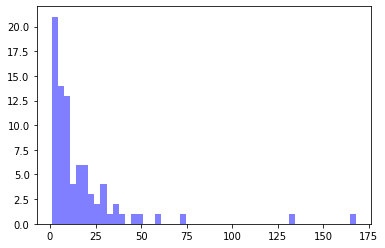

In [13]:
count0 = pd.read_sql_query("SELECT COUNT(valuenum) FROM stage0 GROUP BY subject_id",c)
n, bins, patches = plt.hist(count0.iloc[:,0], 50, facecolor='blue', alpha=0.5)
plt.show()

Next, make a data frame with the subject id and all the stage0 values for that subject. In order to account for missing values, I will take the average of the values for that subject. 

In [14]:
sub0 = pd.read_sql_query("SELECT subject_id,valuenum FROM Stage0",c)
subjects = np.unique(sub0.iloc[:,0])
maxNum = max(count0.iloc[:,0])
df = pd.DataFrame(np.zeros(shape = (len(subjects),maxNum)), index = subjects) # create dataframe of zeros
for i in range(0,len(subjects)): # go through each row to fill in column values
    valsI = sub0.loc[sub0["subject_id"] == subjects[i],"valuenum"]
    if (len(valsI) < maxNum): # if there will be missing values, fill them in with the average of the values
        avgI = sum(valsI)/len(valsI) # find average of current values
        df.iloc[i,range(0,len(valsI))] = valsI # fill current values
        df.iloc[i,range(len(valsI),len(df.columns))] = avgI # fill the rest with the average
    else:
        df.iloc[i,:] = valsI # fill current values

Scale data perform principal component analysis (PCA)

In [34]:
# scale data
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

# pca with 10 components
pca = PCA(n_components = 10)
pca.fit(scaled)
scaled_pca = pca.transform(scaled)

Perform k-means clustering on data to determine what clusters form in group before stage1 AKI

In [35]:
# perform k-means clustering on scaled data
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scaled_pca)

KMeans(n_clusters=4)

Add kmeans clusters and pca values to original feature dataframe

In [36]:
df["pca_1"] = scaled_pca[:,0]
df["pca_2"] = scaled_pca[:,1]
df["clusters"] = kmeans.labels_

Plot PCA with kmeans clusters using matplotlib

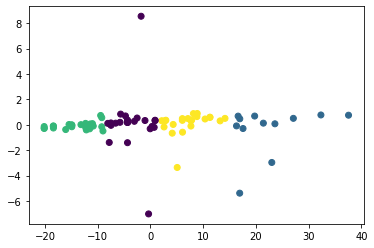

In [37]:
x = df["pca_1"]
y = df["pca_2"]
clusters = df["clusters"]

plt.scatter(x,y,c = clusters)
plt.show()

Find if those subjects become AKI stage0, stage1, stage2, or stage3

In [38]:
future = pd.read_sql_query("SELECT subject_id,charttime, valuenum FROM CR WHERE subject_id IN (SELECT subject_id FROM stage0)",c)
future["stage"] = 0
future.loc[(future["valuenum"] >= 1.23) & (future["valuenum"] <= 1.62),"stage"] = 1
future.loc[(future["valuenum"] >= 1.7) & (future["valuenum"] <= 2.47),"stage"] = 2
future.loc[future["valuenum"] > 2.47,"stage"] = 3

Get last timepoint stages for each subject

In [39]:
df["stage"] = 0
# go through each row of the dataframe, find max time point for subject, extract stage 
for i in range(0,len(df)):
    future_i = future.loc[future["subject_id"] == df.index[i]]
    maxI = max(future_i["charttime"]) # get value of time series data
    stageI = future_i.loc[future_i["charttime"] == maxI,"stage"]
    if (len(stageI) > 1):
        stageI = stageI.iloc[0]
    df.iloc[i,171] = stageI

Plot these stages with the pca dimensions

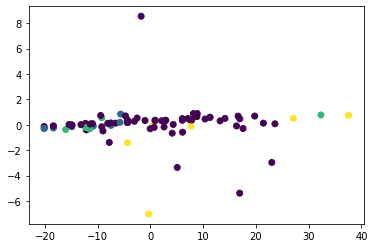

In [40]:
stage = df["stage"]

plt.scatter(x,y,c = stage)
plt.show()

Assess performance of predicting future stage of patient using creatinine values from before stage 1 of AKI

In [41]:
# Assuming stage0 = cluster 0, stage1 = cluster 1, stage2 = cluster2, stage3 = cluster3
labels = df["stage"].copy()
accScore = adjusted_rand_score(df["clusters"],labels)
print("Accuracy scores assuming stage0 = cluster 0, stage1 = cluster 1, stage2 = cluster2, stage3 = cluster3 ... ",accScore)

# Assuming stage0 = cluster 3, stage1 = cluster 2, stage2 = cluster 1, stage3 = cluster 0
labels = df["stage"].copy()
labels[labels == 0] = 3
labels[labels == 1] = 2
labels[labels == 2] = 1
labels[labels == 3] = 0
accScore = adjusted_rand_score(df["clusters"],labels)
print("Accuracy scores assuming stage0 = cluster 3, stage1 = cluster 2, stage2 = cluster 1, stage3 = cluster 0 ... ",accScore)

Accuracy scores assuming stage0 = cluster 0, stage1 = cluster 1, stage2 = cluster2, stage3 = cluster3 ...  0.015126379245249951
Accuracy scores assuming stage0 = cluster 3, stage1 = cluster 2, stage2 = cluster 1, stage3 = cluster 0 ...  0.020556710205414993


In [66]:
vals = pd.read_csv('combination4.txt', delimiter = "\t", header = None) # import table with all possible combinations of 0,1,2,3
predict = pd.DataFrame(np.zeros(shape = (24,5)))
predict.columns = ['stage0','stage1','stage2','stage3', 'score']
predict.iloc[:,range(0,4)] = vals

Fill in score values using the values in the data frame as the predicted cluster label for the stages

In [68]:
for i in range(0,len(predict)):
    labels = df["stage"].copy()
    labels[labels == 0] = predict.iloc[i,0] # replace stage is 0 with cluster in data frame (stage0 column)
    labels[labels == 1] = predict.iloc[i,1] # replace stage is 1 with cluster in data frame (stage1 column)
    labels[labels == 2] = predict.iloc[i,2] # replace stage is 2 with cluster in data frame (stage2 column)
    labels[labels == 3] = predict.iloc[i,3] # replace stage is 3 with cluster in data frame (stage3 column)
    predict.iloc[i,4] = adjusted_rand_score(df["clusters"],labels) # get accuracy score with this combination i

In [69]:
predict

,stage0,stage1,stage2,stage3,score
0,1.0,2.0,3.0,0.0,0.000000
1,1.0,2.0,0.0,3.0,0.009996
2,1.0,3.0,2.0,0.0,0.007735
3,1.0,3.0,0.0,2.0,0.007735
4,1.0,0.0,2.0,3.0,0.013968
5,1.0,0.0,3.0,2.0,0.008560
6,2.0,1.0,3.0,0.0,-0.006325
7,2.0,1.0,0.0,3.0,0.001110
8,2.0,3.0,1.0,0.0,-0.002121
9,2.0,3.0,0.0,1.0,-0.002121


In [74]:
c.close() # close connection